In [1]:
import os
import yaml
import copy
import pickle
import ml_collections
import wandb, signatory

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import path as pt
from tqdm import tqdm
sns.set_style("darkgrid")  # 원하는 스타일 선택

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from src.utils import *

In [2]:
# Load configuration dict
config_dir = 'configs/config.yaml'
with open(config_dir) as file:
    config = ml_collections.ConfigDict(yaml.safe_load(file))
    
torch.cuda.set_device(0)
if (config.device == "cuda" and torch.cuda.is_available()):
    config.update({"device": "cuda:0"}, allow_val_change=True)    
else:
    config.update({"device": "cpu"}, allow_val_change=True)

set_seed(config.seed)

### Data Preprocess

In [3]:
df = pd.read_csv("./data/indices.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)
df = df.apply(pd.to_numeric).astype(float)

log_returns = np.diff(np.log(df), axis=0)
log_returns_scaled, scalers = scaling(log_returns)

# Step 4: Prepare initial prices and create rolling windows
init_price = torch.from_numpy(np.array(df)[:-(config.n_steps), :]).float().unsqueeze(1)
log_returns_scaled = torch.from_numpy(rolling_window(log_returns_scaled, config.n_steps)).float()
log_returns_org = torch.from_numpy(rolling_window(log_returns, config.n_steps)).float()
print('log_returns_scaled:', log_returns_scaled.shape)

log_returns_scaled: torch.Size([5934, 256, 6])


### Log Return Path

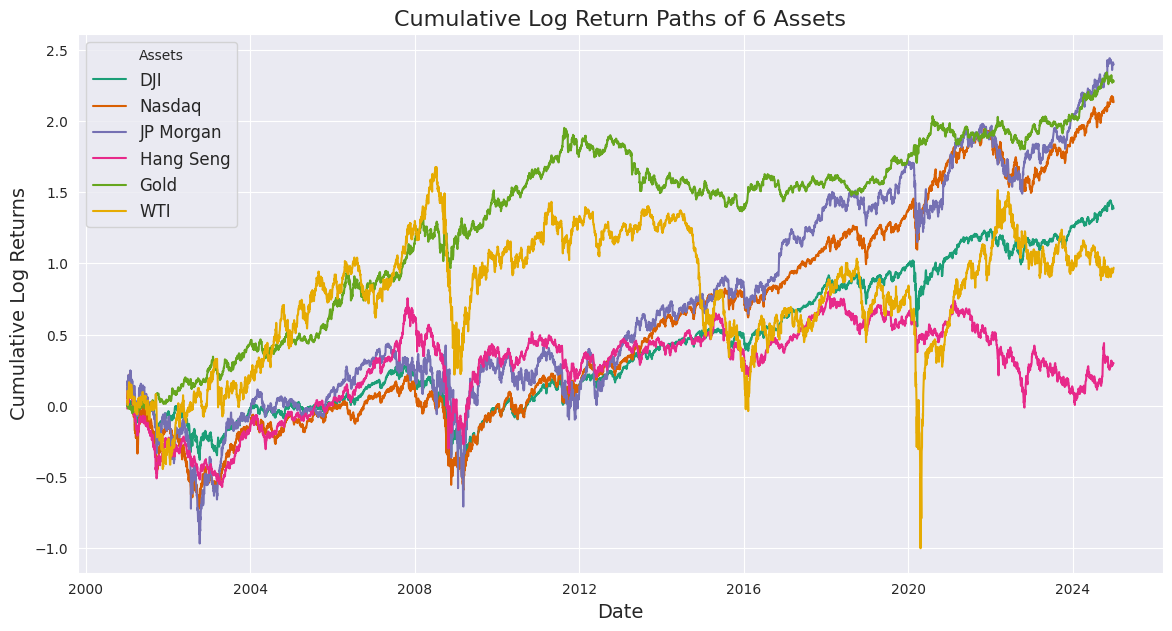

In [4]:
# Step 3: Compute cumulative log returns
cumulative_log_returns = np.cumsum(log_returns, axis=0)
custom_palette = sns.color_palette("Dark2", 6)
# Step 4: Create a DataFrame for cumulative log returns
cumulative_log_returns_df = pd.DataFrame(
    cumulative_log_returns,
    index=df.index[1:],  # Adjust index for cumulative log returns
    columns=df.columns
)

# Step 5: Plot the cumulative log return paths
plt.figure(figsize=(14, 7))
i = 0
for col in cumulative_log_returns_df.columns:
    plt.plot(cumulative_log_returns_df.index, cumulative_log_returns_df[col], label=col, color=custom_palette[i])
    i += 1

plt.title("Cumulative Log Return Paths of 6 Assets", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Cumulative Log Returns", fontsize=14)
plt.legend(title="Assets", fontsize=12)
plt.grid(True)
plt.show()

### Generative models for time series generation

### Data Construction

We divide the data into training and validation set for the offline evaluation of our model

In [5]:
train_size = int(log_returns_scaled.shape[0] * 0.7)

training_data = log_returns_scaled[:train_size]
test_data = log_returns_scaled[train_size:]

train_init_price = init_price[:train_size]
test_init_price = init_price[train_size:]

training_data_org = log_returns_org[:train_size]
test_data_org = log_returns_org[train_size:]

print("training_data: ", training_data.shape)
print("test_data: ", test_data.shape)

training_data:  torch.Size([4153, 256, 6])
test_data:  torch.Size([1781, 256, 6])


Load the dataset


In [6]:
training_set = TensorDataset(training_data)
test_set = TensorDataset(test_data)

train_dl = DataLoader(training_set, batch_size=config.batch_size, shuffle=True)
test_dl = DataLoader(test_set, batch_size=config.batch_size, shuffle=True)

### Generative model

### Initialize the generator, discriminator and the trainer

In [7]:
from src.baselines.networks.discriminators import TCNDiscriminator
from src.baselines.networks.generators import TCNGenerator
from src.baselines.trainer import *

generators = {}
discriminators = {}

for i in range(config.n_vars):
    generators[i] = TCNGenerator(config).to(config.device)
    discriminators[i] = TCNDiscriminator(config).to(config.device)
trainer = GANTrainer(G=generators, D=discriminators, train_dl=train_dl, config=config)

### Model training and saving

In [8]:
# # Model training
#trainer.fit()

# Model Evaluation

### MVFIT-GAN

In [9]:
full_name = "NEW_3_200_256_Glr_0.0002_Dlr_0.0001_hidden_dim_48_n_steps_256_corr_loss_l1_corr_weight_1.0_f_epoch_40_n_critic_2_gp_10.0_noise_3_Adam_drop_0.0_0.2_8_splitupdate_v2_corrlinear_overall_Adam0.5"

In [10]:
""" Find the best epochs based on 100 days cumulative distribution """
from scipy.stats import wasserstein_distance

min_dist = float('inf')  
best_epoch = 0
window = 100

def compute_avg_emd(real_data, fake_data, window):
    emd = 0
    for i in range(real_data.shape[1]):
        real_dist = rolling_window(real_data[:, i, :].T, window).sum(axis=1).ravel()
        fake_dist = rolling_window(fake_data[:, i, :].T, window).sum(axis=1).ravel()
        emd += wasserstein_distance(real_dist, fake_dist)
    return emd

def load_sub_generator(file_path, config):
    sub_gen = TCNGenerator(config)
    sub_gen.load_state_dict(torch.load(file_path, map_location=config.device))
    return sub_gen.to(config.device).eval()

epochs_to_check = range(150, 174, 2)

min_emd = [float('inf')] * config.n_vars
best_epoch = [None] * config.n_vars

real_data = training_data_org.transpose(1, 2).cpu().numpy()

noise = torch.randn(real_data.shape[0], config.noise_dim, config.n_steps).to(config.device)

for epoch in epochs_to_check:
    for i in range(config.n_vars):
        file_path = os.path.join(f'./results/models/{full_name}/', f"Generator_{epoch}_var_{i}.pt")
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        
        sub_gen = load_sub_generator(file_path, config)        
        with torch.no_grad():
            fake = sub_gen(noise)  
        fake_data = inverse_scaling(fake, scalers, i) 
        emd_val = compute_avg_emd(real_data[:, i:i+1, :], fake_data, window)
        if emd_val < min_emd[i]:
            min_emd[i] = emd_val
            best_epoch[i] = epoch
    
    print(f"Epoch {epoch}: best_epoch = {best_epoch}, min_emd = {min_emd}")

print("\n--- 최종 결과: 각 서브 생성자별 Best Epoch ---")
for i in range(config.n_vars):
    print(f"SubGen {i}: best epoch = {best_epoch[i]}, EMD = {min_emd[i]:.3f}")

Epoch 150: best_epoch = [150, 150, 150, 150, 150, 150], min_emd = [0.012657960076642211, 0.019990099076861455, 0.06629536014440218, 0.025653985750199778, 0.011499444891314528, 0.059733350086938274]
Epoch 152: best_epoch = [152, 152, 152, 150, 152, 152], min_emd = [0.012628332264141192, 0.014162046938998704, 0.02885377209081903, 0.025653985750199778, 0.005854438081143129, 0.042469024000902786]
Epoch 154: best_epoch = [154, 152, 152, 150, 154, 152], min_emd = [0.01193627275409945, 0.014162046938998704, 0.02885377209081903, 0.025653985750199778, 0.0036468622454066675, 0.042469024000902786]
Epoch 156: best_epoch = [154, 152, 152, 150, 154, 152], min_emd = [0.01193627275409945, 0.014162046938998704, 0.02885377209081903, 0.025653985750199778, 0.0036468622454066675, 0.042469024000902786]
Epoch 158: best_epoch = [158, 152, 152, 150, 154, 158], min_emd = [0.010910714027977936, 0.014162046938998704, 0.02885377209081903, 0.025653985750199778, 0.0036468622454066675, 0.04182856103342334]
Epoch 160:

In [11]:
real_data = training_data_org.transpose(1, 2).cpu().numpy()

fake_series_list = []
for i in range(config.n_vars):    
    best_ep = best_epoch[i] 
    file_path = os.path.join(f'./results/models/{full_name}/', f"Generator_{best_ep}_var_{i}.pt")
    
    sub_gen = load_sub_generator(file_path, config)
    with torch.no_grad():
        fake = sub_gen(noise)
    
    fake_data_i = inverse_scaling(fake, scalers, i)
    fake_data_i = torch.tensor(fake_data_i, device=config.device)
    
    fake_series_list.append(fake_data_i)

fake_data = torch.cat(fake_series_list, dim=1)
fake_data = fake_data.cpu().numpy()
print("다변량 시계열 데이터의 shape:", fake_data.shape)

np.save('fake_data.npy', fake_data)

다변량 시계열 데이터의 shape: (4153, 6, 256)


In [12]:
""" Visualize the distribution of the real and fake data """
fake_list = [fake_data[:, i, :] for i in range(fake_data.shape[1])]
real_list = [real_data[:, i, :] for i in range(real_data.shape[1])]

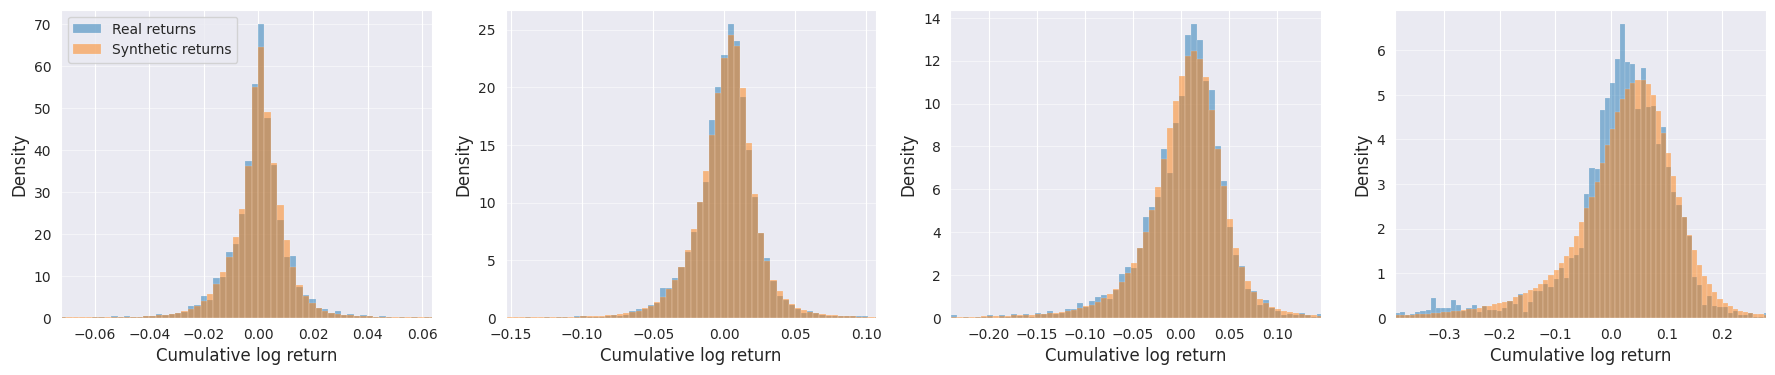

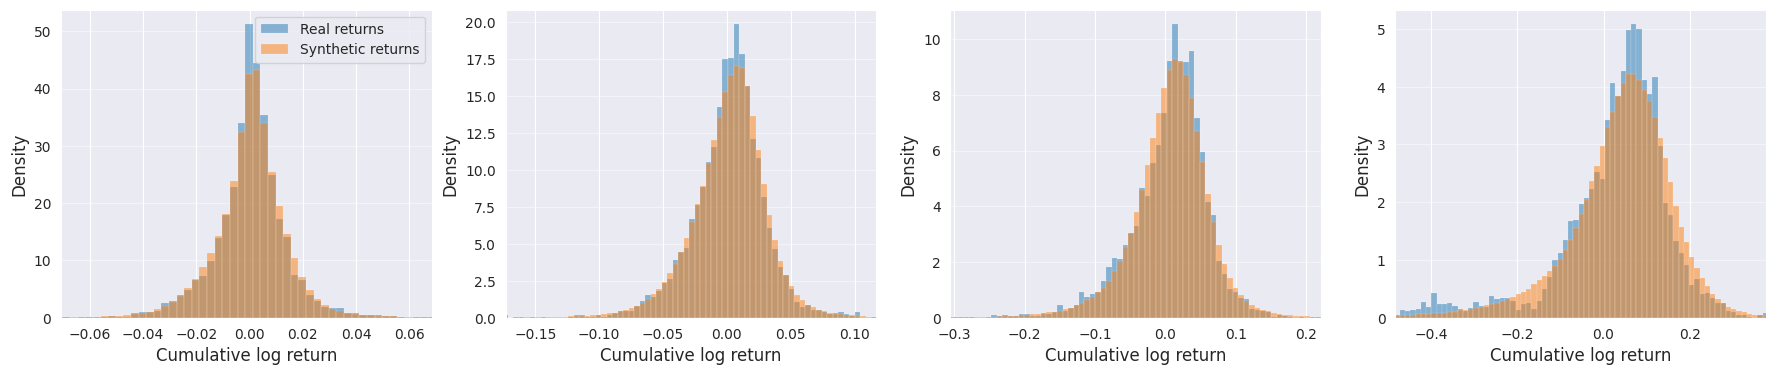

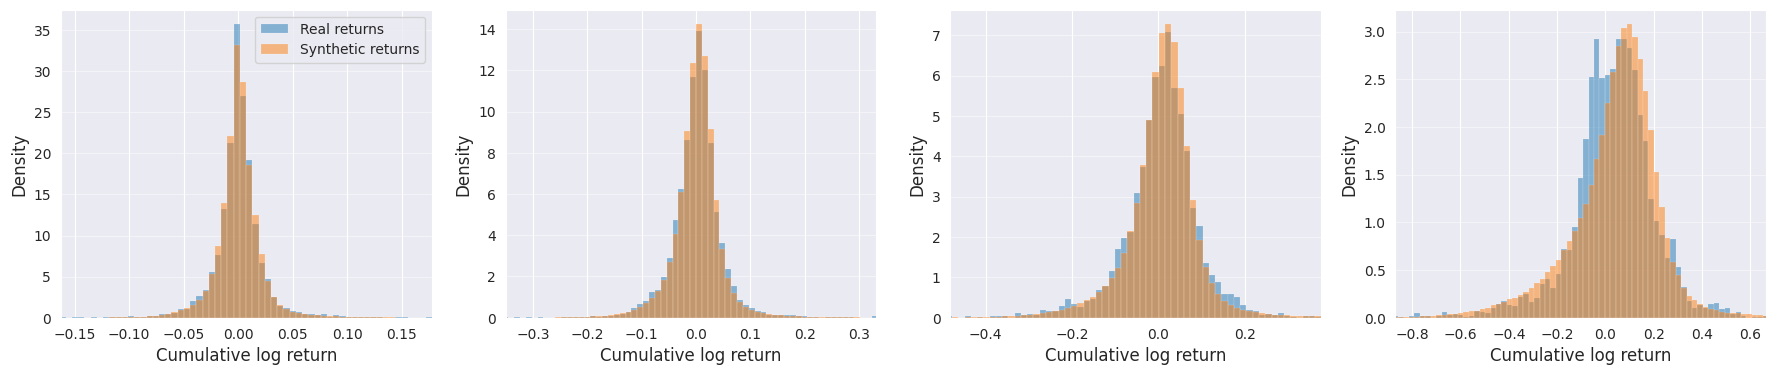

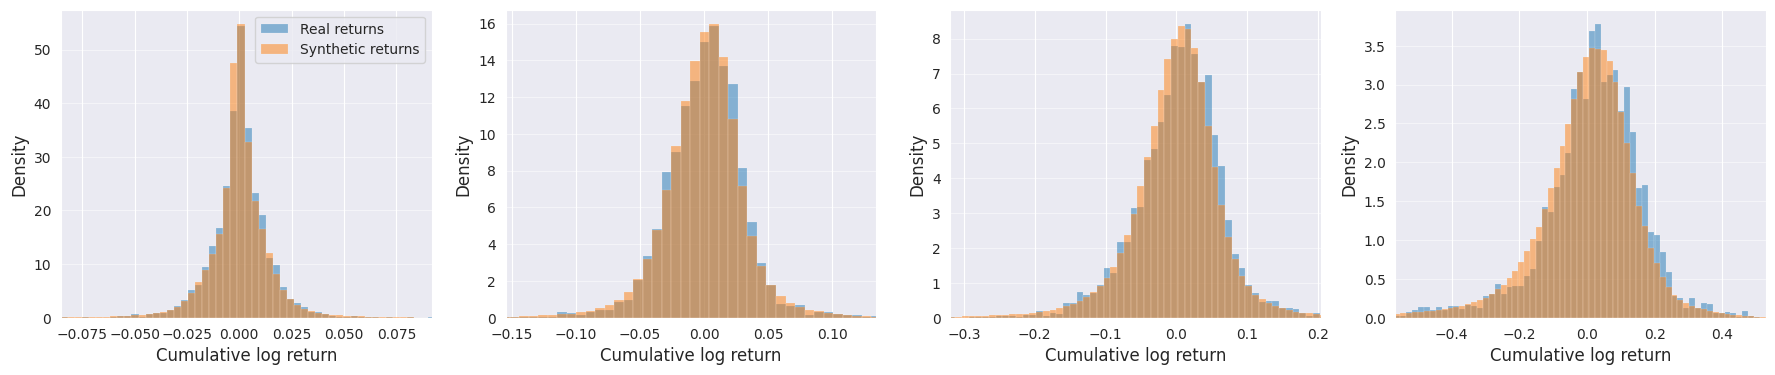

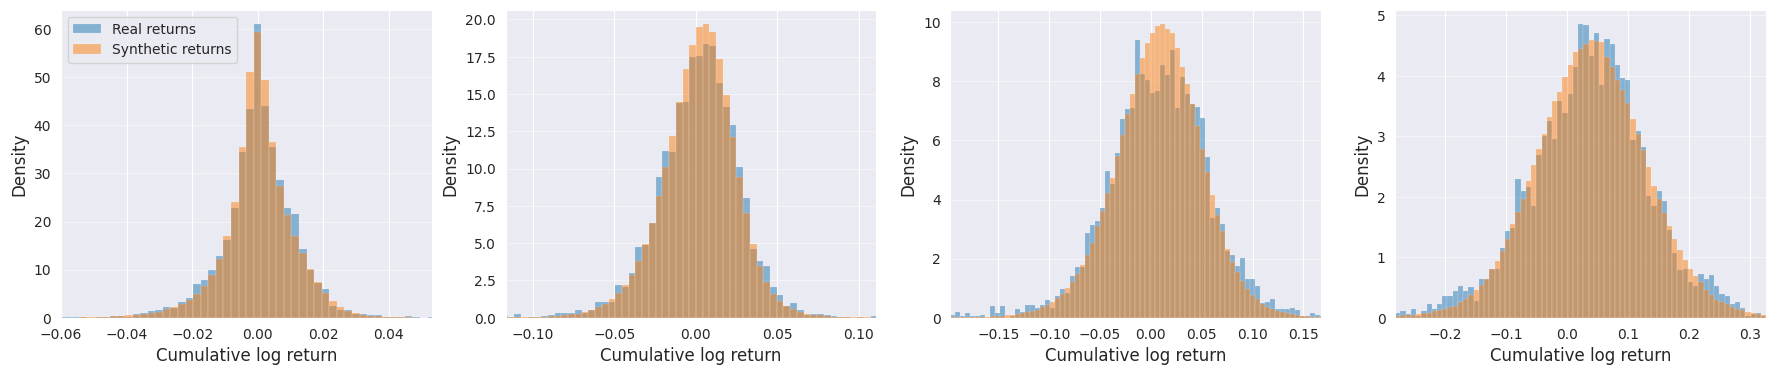

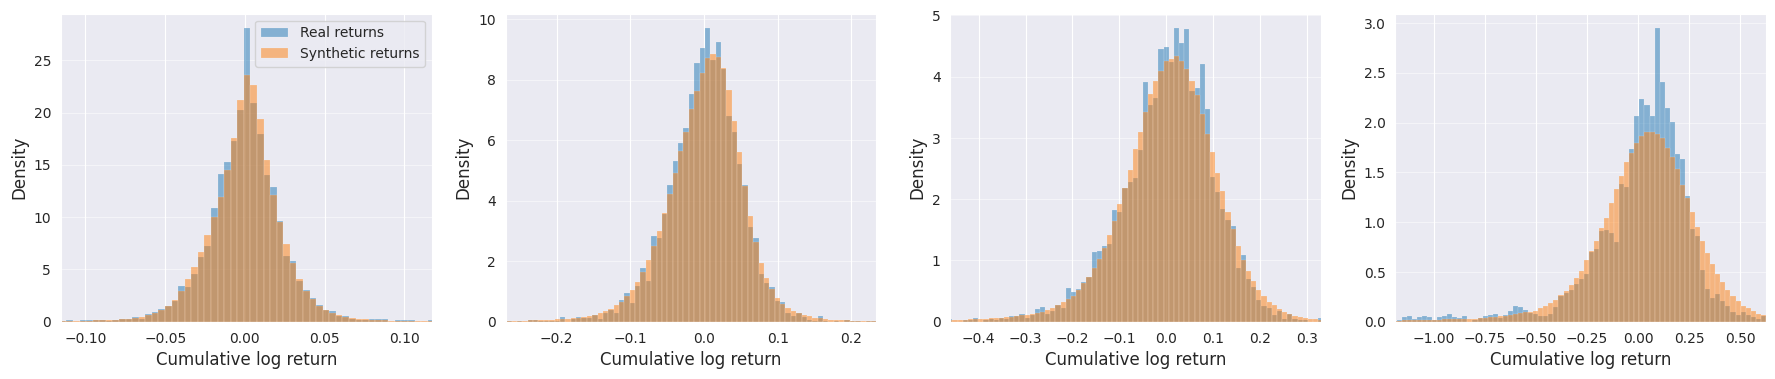

In [13]:
from src.evaluation.eval_gen_quality.gen_quality import *
windows = [1, 5, 20, 100]

plot_distribution_comparison(real_list, fake_list, n_vars=config.n_vars, windows=windows)
plot_distribution_comparison_vertical(real_list, fake_list, n_vars=config.n_vars, windows=windows)

In [14]:
# results_dist = calculate_distribution_scores(real_list, fake_list, n_vars=config.n_vars, windows= windows)
# df_skew_diff, df_kurt_diff = calculate_skew_kurtosis(
#     real_list, fake_list, windows
# )

# print("\n윈도우별 EMD:")
# print(results_dist['EMD'])

# print("\n윈도우별 KS:")
# print(results_dist['KS'])

# print("\n윈도우별 Skewness Difference:") 
# print(df_skew_diff)

# print("\n윈도우별 Kurtosis Difference:")
# print(df_kurt_diff)

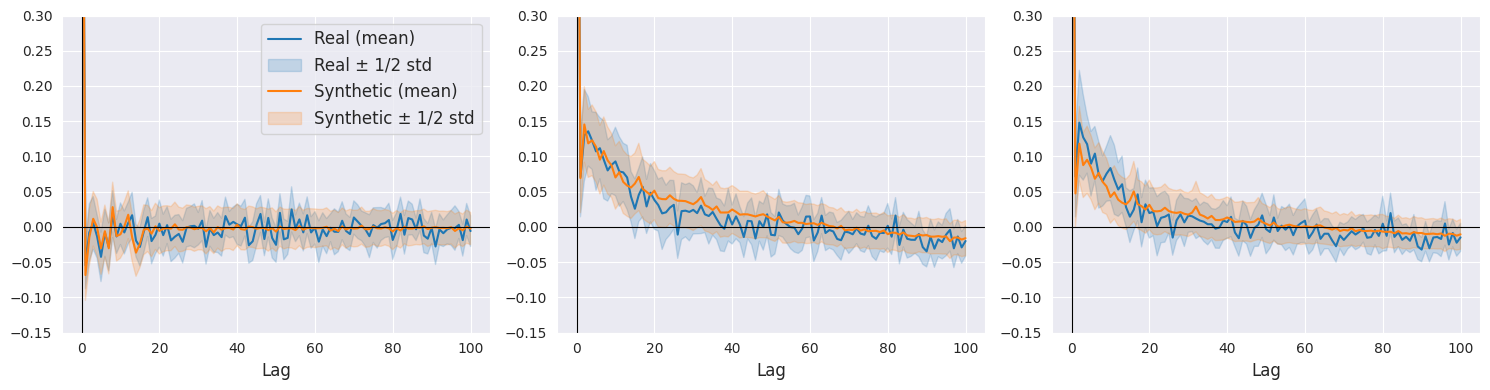

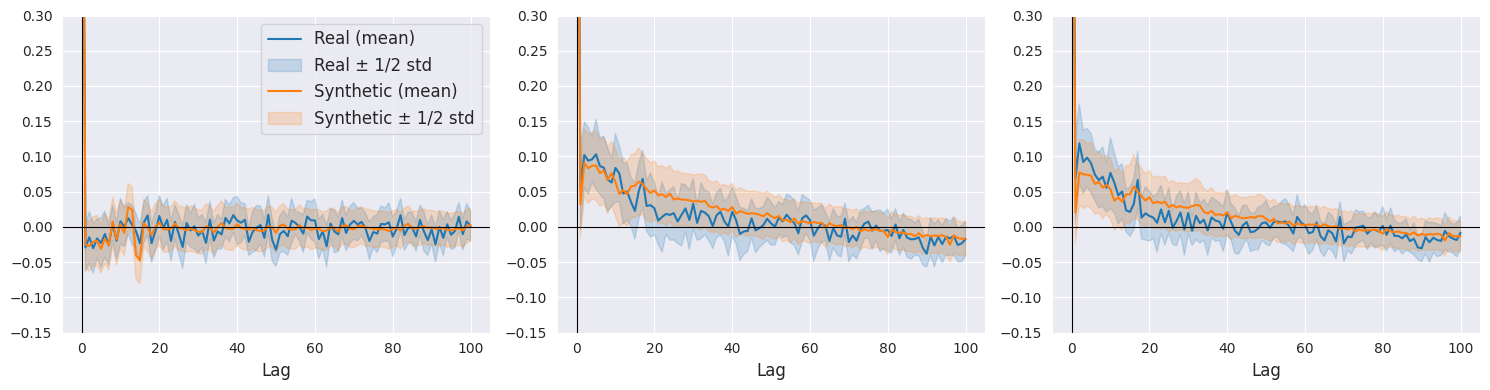

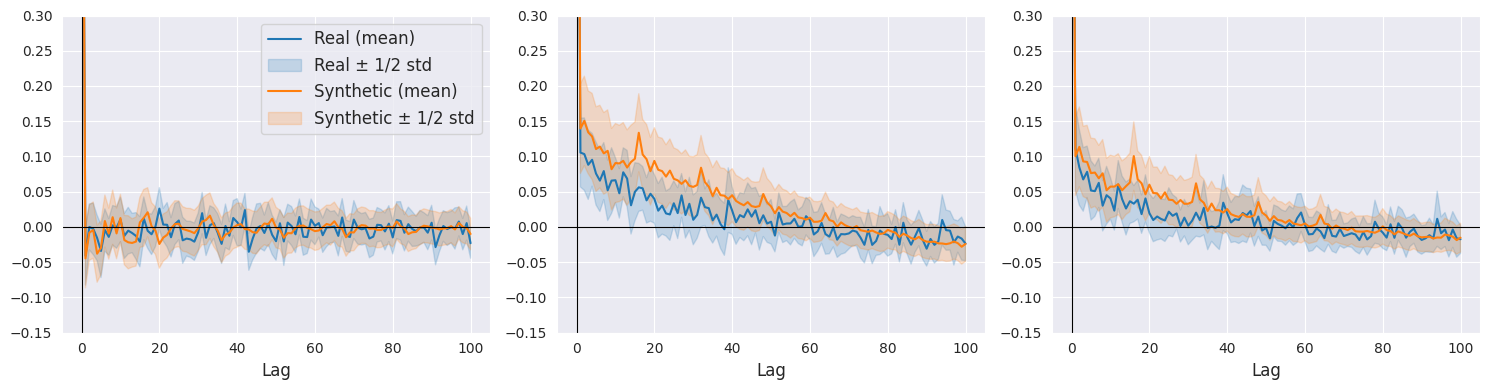

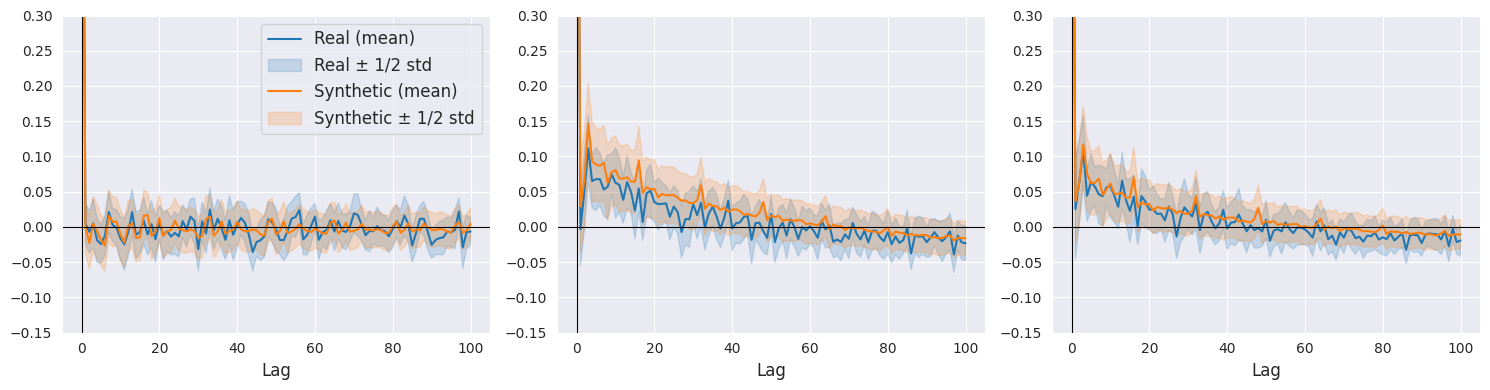

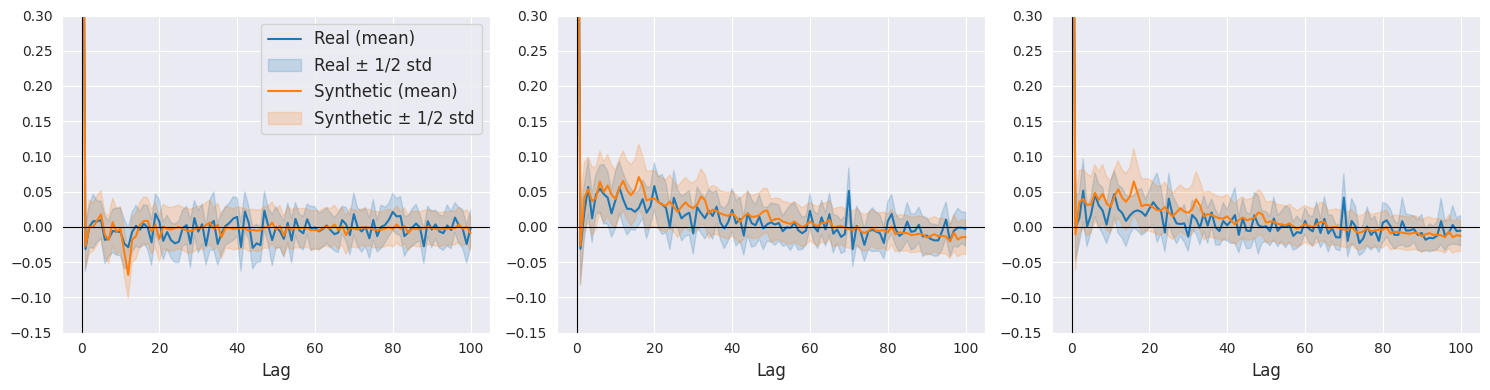

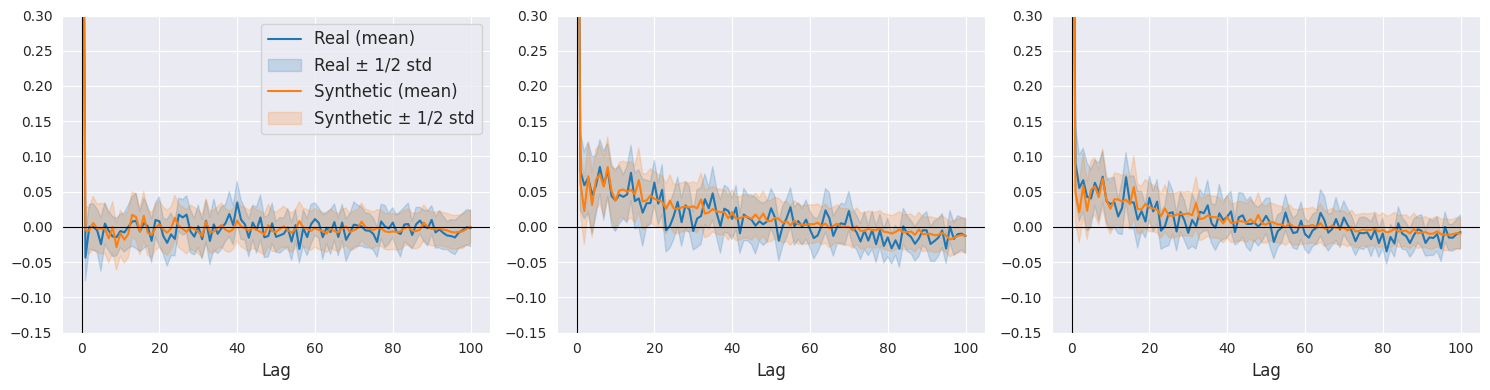

In [15]:
plot_acf_comparison(real_list, fake_list, n_vars=config.n_vars, lags=100)
plot_acf_comparison_vertical(real_list, fake_list, n_vars=config.n_vars, lags=100)

In [16]:
acf_scores, avg_scores = calculate_acf_score(real_list, fake_list, lags=40, loss_type='mse')

print("=== ACF Scores (per group) ===")
for group_name, transform_scores in acf_scores.items():
    print(f"{group_name}:")
    for transform_title, val in transform_scores.items():
        print(f"  - {transform_title}: loss={val}")

print("\n=== Overall Average Scores ===")
for transform_title, mean_of_means in avg_scores.items():
    print(f"{transform_title}: mean of means={mean_of_means}")

=== ACF Scores (per group) ===
Group 1:
  - Identity log returns: loss=0.0001
  - Absolute log returns: loss=0.0003
  - Squared log returns: loss=0.0003
Group 2:
  - Identity log returns: loss=0.0002
  - Absolute log returns: loss=0.0004
  - Squared log returns: loss=0.0005
Group 3:
  - Identity log returns: loss=0.0002
  - Absolute log returns: loss=0.0018
  - Squared log returns: loss=0.0008
Group 4:
  - Identity log returns: loss=0.0001
  - Absolute log returns: loss=0.0005
  - Squared log returns: loss=0.0002
Group 5:
  - Identity log returns: loss=0.0002
  - Absolute log returns: loss=0.0003
  - Squared log returns: loss=0.0004
Group 6:
  - Identity log returns: loss=0.0002
  - Absolute log returns: loss=0.0003
  - Squared log returns: loss=0.0003

=== Overall Average Scores ===
Identity log returns: mean of means=0.0002
Absolute log returns: mean of means=0.0006
Squared log returns: mean of means=0.0004


[Correlation Loss - MAE]
Loss: 0.018


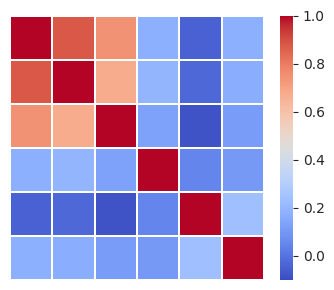

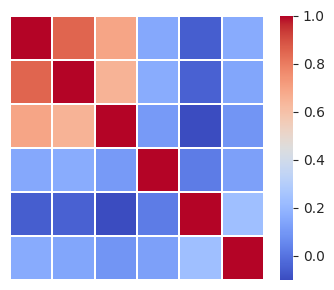

In [17]:
real_mean_corr = ccf_mean(np.transpose(real_data, (0, 2, 1)))
fake_mean_corr = ccf_mean(np.transpose(fake_data, (0, 2, 1)))

loss_ccf = ccf_loss(real_mean_corr, fake_mean_corr, loss_type='mae')

print("[Correlation Loss - MAE]")
print(f"Loss: {loss_ccf}")
    
plot_ccf_heatmap(real_mean_corr, "Real", annot=False)
plot_ccf_heatmap(fake_mean_corr, "Fake", annot=False)


In [18]:
real_mean_ccf_lag = ccf_lag_mean(np.transpose(real_data, (0, 2, 1)), lag=10)
fake_mean_ccf_lag = ccf_lag_mean(np.transpose(fake_data, (0, 2, 1)), lag=10)

loss_ccf_lag = ccf_lag_loss(real_mean_ccf_lag, fake_mean_ccf_lag, loss_type='mae')

print("[Partial CCF Loss - MAE]")
print(f"Loss: {loss_ccf_lag}")

[Partial CCF Loss - MAE]
Loss: 0.0233


In [19]:
leverage_scores, overall_mean = leverage_effect_loss(
    real_list, 
    fake_list, 
    lags=40, 
    loss_type='mse'
)

print("\n=== Leverage Effect Loss (Mean vs. Mean) ===")
for group, loss in leverage_scores.items():
    print(f"{group}: {loss}")
print(f"Overall Mean Loss: {overall_mean}")

[Group 1] Leverage Loss (MSE) => 0.0004
[Group 2] Leverage Loss (MSE) => 0.0004
[Group 3] Leverage Loss (MSE) => 0.0002
[Group 4] Leverage Loss (MSE) => 0.0004
[Group 5] Leverage Loss (MSE) => 0.0003
[Group 6] Leverage Loss (MSE) => 0.0002

[Overall] Leverage Loss (MSE) => 0.0003

=== Leverage Effect Loss (Mean vs. Mean) ===
Group 1: 0.0004
Group 2: 0.0004
Group 3: 0.0002
Group 4: 0.0004
Group 5: 0.0003
Group 6: 0.0002
Overall Mean Loss: 0.0003


Best Sample MAE: 0.0122


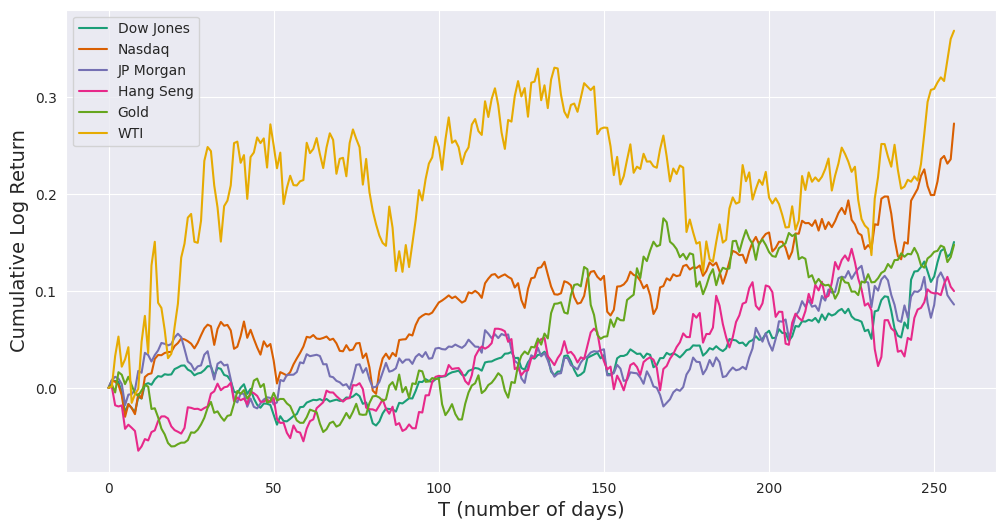

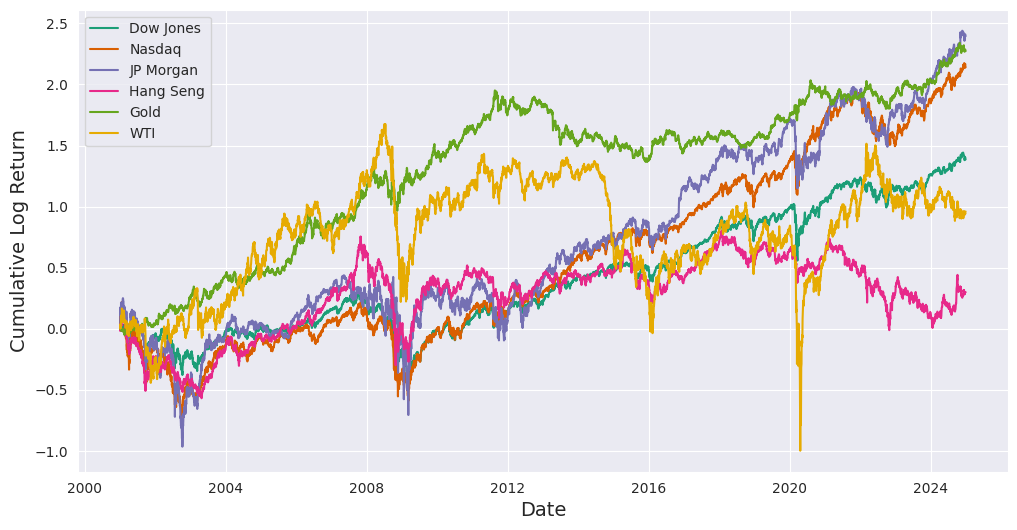

In [20]:
asset_labels = ['Dow Jones', 'Nasdaq', 'JP Morgan', 'Hang Seng', 'Gold', 'WTI']
    
plot_best_generated_sample(fake_data, real_mean_corr, asset_labels)
plot_real_cumulative_log_returns(df, asset_labels)

### Synthetic data generation

### Model evaluation

We compute the performance of our model by first generating the price process, apply the prespecified trading strategies and compare the resulting PnL process using the real and fake data.

In [21]:
from src.evaluation.eval_portfolio.strategies import log_return_to_price

eval_size = real_data.shape[0]

fake_data_torch = torch.from_numpy(fake_data).float().transpose(1, 2)
real_data_torch = torch.from_numpy(real_data).float().transpose(1, 2)

test_init_price = train_init_price
test_init_price[:] = 100

fake_prices = log_return_to_price(fake_data_torch[:eval_size], test_init_price[:eval_size])
real_prices = log_return_to_price(real_data_torch[:eval_size], test_init_price[:eval_size])

equal_weight: {'var_abs_mean': 0.0345, 'var_rel_mean': 0.0408, 'es_abs_mean': 0.083, 'es_rel_mean': 0.1126}


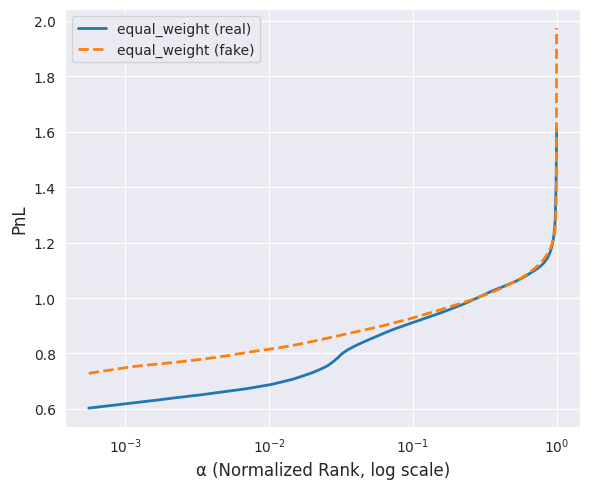

42
47
mean_reversion: {'var_abs_mean': 0.0379, 'var_rel_mean': 0.048, 'es_abs_mean': 0.107, 'es_rel_mean': 0.1577}


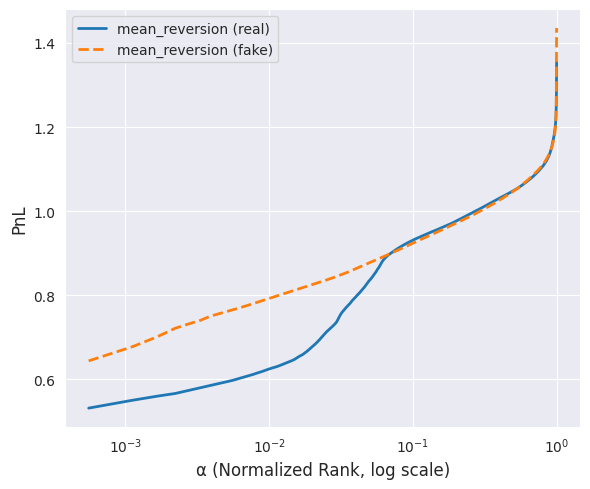

52
51
trend_following: {'var_abs_mean': 0.0124, 'var_rel_mean': 0.0136, 'es_abs_mean': 0.032, 'es_rel_mean': 0.0376}


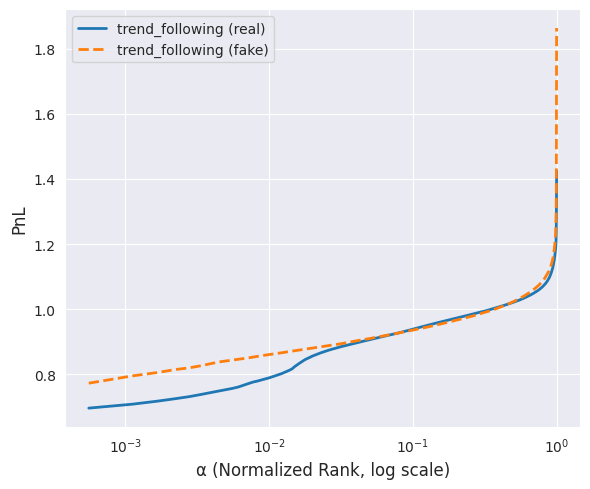

76
72
vol_trading: {'var_abs_mean': 0.0104, 'var_rel_mean': 0.0116, 'es_abs_mean': 0.0168, 'es_rel_mean': 0.0194}


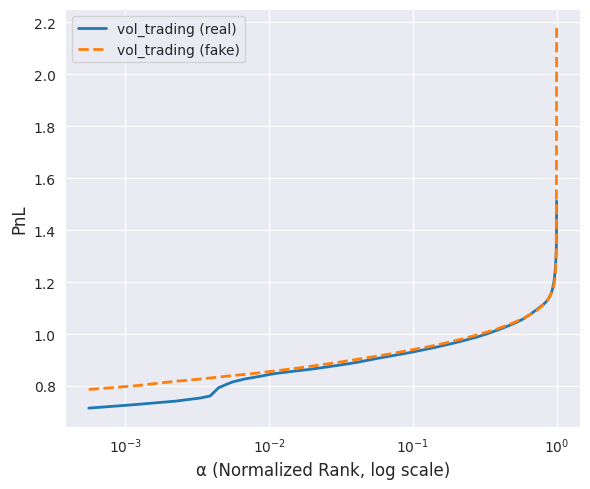

var_abs_mean 0.0238
var_rel_mean 0.0285
es_abs_mean 0.0597
es_rel_mean 0.0818


In [22]:
from src.evaluation.eval_portfolio.strategies import log_return_to_price
from src.evaluation.eval_portfolio.summary import *

config_dir = 'src/evaluation/eval_portfolio/config.yaml'
with open(config_dir) as file:
    eval_config = ml_collections.ConfigDict(yaml.safe_load(file))

all_positive = (fake_prices > 0).all()
if not all_positive:
    raise ValueError("Sanity Check Failed: Some fake prices are not positive.")

res_dict = {
    "var_abs_mean": 0.,
    "var_rel_mean": 0.,
    "es_abs_mean": 0.,
    "es_rel_mean": 0.,
}

num_strat = 4  # 전략 개수

with torch.no_grad():
    for strat_name in ['equal_weight', 'mean_reversion', 'trend_following', 'vol_trading']:                    
        subres_dict, pnl_real, pnl_fake = full_evaluation(fake_prices, real_prices, eval_config, strat_name=strat_name)        
        filtered_means = {
            k: round(v, 4) for k, v in subres_dict.items() if '_mean' in k
        }
        print(f"{strat_name}: {filtered_means}")        
        # 전략별 plot 호출
        plot_cumulative_pnl_quantiles(pnl_real, pnl_fake, strat_name)

        for k in res_dict:            
            res_dict[k] += subres_dict[k] / num_strat

for k, v in res_dict.items():
    print(k, round(v, 4))